In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
abstracts = pd.read_csv('../data/abstracts_df.csv', index_col=0)

In [4]:
abstracts.head()

,abstract
0,\n1. Bone. 2018 Sep 24. pii: S8756-3282(18)303...
1,\n\n\n2. Neurosci Lett. 2018 Sep 24. pii: S03...
2,\n\n\n3. Antivir Ther. 2018 Sep 27. doi: 10.3...
3,\n\n\n4. Fetal Pediatr Pathol. 2018 Sep 27:1-...
4,\n\n\n5. Clin Exp Immunol. 2018 Oct;194(1):17...


### removing short abstracts
- very old abstracts (from the beginning of the 20th century) are only indexed and do not contain an abstract, just a title and authors
    - have no valuable information
    - can be cut by removing abstracts that don't meet a certain length
- the column with the abstract lengths is dropped at the end because it is not needed anymore

In [5]:
abstracts['abstract_length'] = abstracts.abstract.str.len()

In [6]:
abstracts_length = abstracts.sort_values('abstract_length', ascending=False)

In [7]:
abstracts_length.describe()

,abstract_length
count,77886.000000
mean,1644.860476
std,971.636945
min,68.000000
25%,912.000000
50%,1782.000000
75%,2270.000000
max,15076.000000


The minimum length of abstract is 68 characters, the maximum is 15076 characters.

In [8]:
abstracts_length.head(15)

,abstract,abstract_length
2720,[Indexed for MEDLINE]\n\n\n2719. Nat Commun....,15076
17569,[Indexed for MEDLINE]\n\n\n17567. Lancet Dia...,14923
8500,\n\n\n8499. Int J Epidemiol. 2016 Oct;45(5):1...,12420
10380,[Indexed for MEDLINE]\n\n\n10378. JAMA. 2016...,11557
27730,[Indexed for MEDLINE]\n\n\n27728. Diabetolog...,10961
17781,[Indexed for MEDLINE]\n\n\n17779. JAMA. 2014...,10515
4638,[Indexed for MEDLINE]\n\n\n4637. Am J Hum Ge...,10357
33364,[Indexed for MEDLINE]\n\n\n33362. Crit Rev F...,10314
33332,\n\n\n33330. Ont Health Technol Assess Ser. 2...,10204
43318,\n\n\n43316. Ont Health Technol Assess Ser. 2...,10176


A few abstracts are really long and are checked if they are properly split.

In [9]:
print(abstracts_length.iloc[0,0])

  [Indexed for MEDLINE]


2719. Nat Commun. 2018 Jan 17;9(1):260. doi: 10.1038/s41467-017-02662-2.

Genome-wide association study in 79,366 European-ancestry individuals informs the
genetic architecture of 25-hydroxyvitamin D levels.

Jiang X(1)(2), O'Reilly PF(3), Aschard H(1)(4), Hsu YH(5)(6)(7), Richards JB(8), 
Dupuis J(9)(10), Ingelsson E(11)(12), Karasik D(5), Pilz S(13), Berry D(14),
Kestenbaum B(15), Zheng J(16), Luan J(16), Sofianopoulou E(17), Streeten EA(18), 
Albanes D(19), Lutsey PL(20), Yao L(20), Tang W(20), Econs MJ(21), Wallaschofski 
H(22)(23), Völzke H(23)(24), Zhou A(25), Power C(14), McCarthy MI(26)(27)(28),
Michos ED(29)(30), Boerwinkle E(31), Weinstein SJ(19), Freedman ND(19), Huang
WY(32), Van Schoor NM(33), van der Velde N(34)(35), Groot LCPGM(36), Enneman
A(34), Cupples LA(9)(10), Booth SL(37), Vasan RS(10), Liu CT(9), Zhou Y(9),
Ripatti S(38), Ohlsson C(39), Vandenput L(39), Lorentzon M(40), Eriksson
JG(41)(42), Shea MK(37), Houston DK(43), Kritchevsky SB(43)

The abstracts are so extremely long because a lot of authors are part of the study and all of them and their universities are listes. The split worked properly.

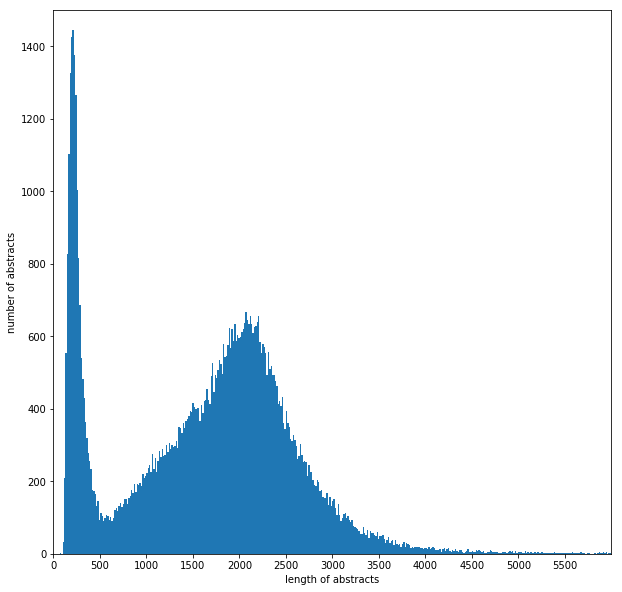

In [10]:
plt.figure(figsize=(10,10))
plt.hist(abstracts['abstract_length'], bins=1000)
plt.xlabel('length of abstracts')
plt.ylabel('number of abstracts')
plt.xlim(0,6000)
plt.ylim(0,1500)
plt.xticks(np.arange(0, 6000, 500.0))
plt.show()

There are so many extremely short abstracts that a big peak is obvious. This peak needs to be removed. Cut-off is set at a minimum length of 500 characters.
The really long abstracts were cut-off in this graph to have a better visualisation of the peaks.

In [11]:
abstracts = abstracts[abstracts['abstract_length'] > 500]

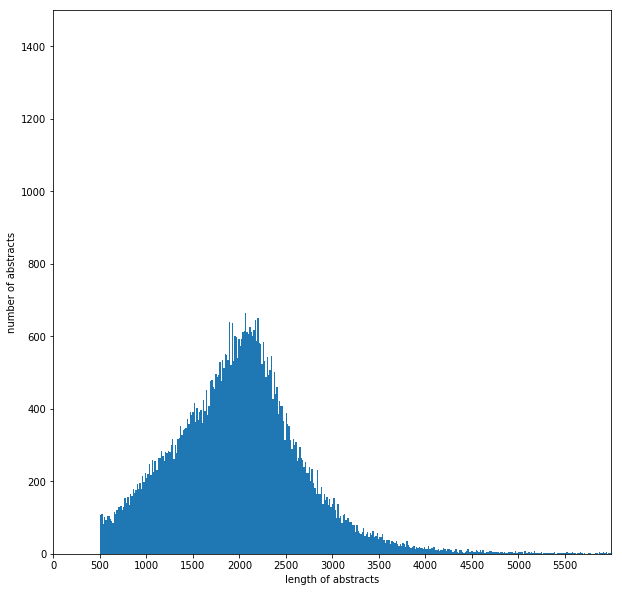

In [12]:
plt.figure(figsize=(10,10))
plt.hist(abstracts['abstract_length'], bins=1000)
plt.xlabel('length of abstracts')
plt.ylabel('number of abstracts')
plt.xlim(0,6000)
plt.ylim(0,1500)
plt.xticks(np.arange(0, 6000, 500.0))
plt.show()

In [13]:
abstracts.drop('abstract_length', axis=1, inplace=True)

### Formatting the abstracts
- the numbering is removed
- the new lines are removed

In [14]:
# remove numbering (for details see file 'text_to_dataframe')
abstracts['abstract'] = abstracts['abstract'].str.replace('(\n+\d+\.)', '')

# whitespaces in the beginning are stripped
abstracts['abstract'] = abstracts['abstract'].str.lstrip()

In [15]:
abstracts['abstract'] = abstracts['abstract'].str.replace('\n+', ' ')
abstracts['abstract'] = abstracts['abstract'].str.replace('\s+', ' ')

In [16]:
abstracts.to_csv('../data/cleaned_abstracts.csv')

### Getting only the abstracts that contain signifi*
- signifi* = significance, significant, significantly
- since significa* can start with a capital letter, all letters are made lower case
- every row with the abstract containing a variation of signifi* is pulled
- abstracts that just contain "significance:" as to explain the significance of the paper and not the results are removed

In [17]:
abstracts['abstract'] = abstracts['abstract'].str.lower()
abstracts = abstracts[abstracts.abstract.str.contains('signifi\D+') == True]
print(f'Number of abstracts: {len(abstracts)}')

Number of abstracts: 25083


In [18]:
abstracts = abstracts[abstracts.abstract.str.contains('significance:') == False]
print(f'Remaining abstracts: {len(abstracts)}')

Remaining abstracts: 24982


In [19]:
abstracts.reset_index(drop=True, inplace=True)

### Labelling the abstracts
- possible labels for 'significant' are: 'yes', 'no', 'both'
- filters are used to label as many abstracts as possible
    - abstracts containing no/not/non-signifi* are labelled as 'no'
    - unlabelled abstracts are checked by hand to generate the filter for 'yes' and improve the filter for 'no'
    - filter for 'yes' and 'no' are combined to gererate filter for 'both'
- the labelled data will be used to train a model, to predict the labels for the unlabelled data

In [20]:
abstracts['significant'] = np.zeros((len(abstracts), 1))

In [21]:
no = r'no signifi|not signifi|non-signifi|did not vary signifi|any signifi|not statistically signifi|without signifi'
abstracts['significant'][abstracts['abstract'].str.contains(no)] = 'no'

In [22]:
yes = r'were signific|a signifi|was signifi|highly signifi|very signifi|significantly \D+ed\
|more signifi|most signifi|less signifi|\D+ed signifi\D+|direct signifi|signifi\D+ associat\D+|\D+s signifi\
had signifi'
abstracts['significant'][abstracts['abstract'].str.contains(yes)] = 'yes'

In [23]:
abstracts['significant'][(abstracts['abstract'].str.contains(yes)) & (abstracts['abstract'].str.contains(no))] = 'both'

### Result of by-hand labelling

In [24]:
abstracts.groupby('significant').count()

,abstract
significant,
0.0,3905
both,4180
no,2036
yes,14861


In [25]:
print(f'{len(abstracts)-3625} abstracts ({np.round((len(abstracts)-3625)/len(abstracts)*100)} %) could successfully be \
labelled succesfully')
print(f'3625 abstracts ({np.round(3625/len(abstracts)*100)} %) could not be labelled')

21357 abstracts (85.0 %) could successfully be labelled succesfully
3625 abstracts (15.0 %) could not be labelled


# Saving the data to csv

In [26]:
abstracts.to_csv('../data/labelled_data.csv')

# Breast cancer as an example

In [27]:
abstracts_lower = abstracts.copy()
abstracts_lower['abstract'] = abstracts_lower.abstract.str.lower()

In [28]:
signifi = abstracts_lower[abstracts_lower.abstract.str.contains('signifi') == True]
signifi = signifi[signifi.abstract.str.contains('significance:') == False]
breast_cancer = signifi[signifi.abstract.str.contains('breast cancer|mammary carcinoma') == True]
breast_cancer.reset_index(drop=True, inplace=True)

In [29]:
len(breast_cancer)

534

In [30]:
breast_cancer['significant'] = np.zeros((len(breast_cancer), 1))

In [31]:
no = r'no signifi|not signifi|non-signifi|did not vary signifi|any signifi|not statistically signifi|without signifi\
|no longer significant'
breast_cancer['significant'][breast_cancer['abstract'].str.contains(no)] = 'no'

In [32]:
yes = r'were signific|a signifi|was signifi|highly signifi|very signifi|significantly \D+ed\
|more signifi|most signifi|less signifi|\D+ed signifi\D+|direct signifi|signifi\D+ associat\D+|\D+s signifi|\
had signifi'
breast_cancer['significant'][breast_cancer['abstract'].str.contains(yes)] = 'yes'

In [33]:
breast_cancer['significant'][(breast_cancer['abstract'].str.contains(yes)) & (breast_cancer['abstract'].str.contains(no))] = 'both'

In [34]:
count = breast_cancer.groupby('significant').count()
count

,abstract
significant,
0.0,76
both,95
no,44
yes,319


In [35]:
print(f'{len(breast_cancer)-count.iloc[0,0]} abstracts ({np.round((len(breast_cancer)-count.iloc[0,0])/\
len(breast_cancer)*100)} %) could successfully be labelled succesfully')
print(f'{count.iloc[0,0]} abstracts ({np.round(count.iloc[0,0]/len(breast_cancer)*100)} %) could not be labelled')

458 abstracts (86.0 %) could successfully be labelled succesfully
76 abstracts (14.0 %) could not be labelled
